In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import astropy.units as u
import matplotlib.gridspec as gridspec
from astropy.coordinates import Distance
from astropy.cosmology import FlatLambdaCDM
from mcmc_tools import dolinmix_sep, split_data, plotFit_sep, plot_splitdata
from cuts import cosmo_cuts

Reading in data

In [2]:
# master = pd.read_csv('data/master_v3.csv')
master = pd.read_csv('data/master_v3.1.csv')
# Removing any object with no vel, categorical or otherwise
master = master[~np.isnan(master.vel)]

In [3]:
found_cosmo = master[master.foundation == True][['Name','z','vel','vel_err','c_sncosmo','c_err_sncosmo',
                                                 'x0_sncosmo','x0_err_sncosmo','x1_sncosmo','x1_err_sncosmo']]
found_ana = master[master.foundation == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                               'x0_err_snana','x1_snana','x1_err_snana']]

found_cosmo.rename(columns={'c_sncosmo':'c','c_err_sncosmo':'c_err','x0_sncosmo':'x0','x0_err_sncosmo':'x0_err',
                            'x1_sncosmo':'x1','x1_err_sncosmo':'x1_err'},inplace=True)
found_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                          'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)

In [4]:
csp_cosmo = master[master.csp == True][['Name','z','vel','vel_err','c_sncosmo','c_err_sncosmo',
                                                 'x0_sncosmo','x0_err_sncosmo','x1_sncosmo','x1_err_sncosmo']]
csp_ana = master[master.csp == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                               'x0_err_snana','x1_snana','x1_err_snana']]

csp_cosmo.rename(columns={'c_sncosmo':'c','c_err_sncosmo':'c_err','x0_sncosmo':'x0','x0_err_sncosmo':'x0_err',
                            'x1_sncosmo':'x1','x1_err_sncosmo':'x1_err'},inplace=True)
csp_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                          'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)

In [5]:
w09_cosmo = master[master.w09 == True][['Name','z','vel','vel_err','c_sncosmo','c_err_sncosmo','x0_sncosmo',
                                           'x0_err_sncosmo','x1_sncosmo','x1_err_sncosmo']]
w09_ana = master[master.w09 == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                         'x0_err_snana','x1_snana','x1_err_snana']]

w09_cosmo.rename(columns={'c_sncosmo':'c','c_err_sncosmo':'c_err','x0_sncosmo':'x0','x0_err_sncosmo':'x0_err',
                             'x1_sncosmo':'x1','x1_err_sncosmo':'x1_err'},inplace=True)
w09_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                           'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)

Computing "derived parameters" that are not directly measured from the lightcurve

In [6]:
c = 299792.458
def pecvelerr(z, pecvelun=300.0):
    pecvelerr = 5.0/np.log(10) * pecvelun/(c*z)
    return pecvelerr
cosmo = FlatLambdaCDM(H0=70.5, Om0=0.3, Tcmb0=2.725)
mu = lambda z: 5.0*np.log10(Distance(z=z, unit=u.pc, cosmology=cosmo).value) - 5.0
mb = lambda x0: -2.5 * np.log10(x0) + 10.635
mberr = lambda x0, x0err: 2.5 * (x0err / x0) / np.log(10)
shpcor = lambda x0, z, x1: mb(x0) - mu(z) + 0.14*x1
shpcor_err = lambda x0, x0err, x1err, z: np.sqrt(mberr(x0, x0err)**2.0 + 
                                                   (0.14*x1err)**2.0 + 
                                                   pecvelerr(z, pecvelun=300.0)**2.0)

In [7]:
found_cosmo.loc[:,'shp_cor'] = shpcor(found_cosmo.loc[:,'x0'],found_cosmo.loc[:,'z'],
                                    found_cosmo.loc[:,'x1'])
found_cosmo.loc[:,'shp_cor_err'] = shpcor_err(found_cosmo.loc[:,'x0'],found_cosmo.loc[:,'x0_err'],
                                           found_cosmo.loc[:,'x1_err'],found_cosmo.loc[:,'z'])
found_ana.loc[:,'shp_cor'] = shpcor(found_ana.loc[:,'x0'],found_ana.loc[:,'z'],
                                    found_ana.loc[:,'x1'])
found_ana.loc[:,'shp_cor_err'] = shpcor_err(found_ana.loc[:,'x0'],
                                             found_ana.loc[:,'x0_err'],
                                             found_ana.loc[:,'x1_err'],
                                             found_ana.loc[:,'z'])
##########################################################################################
csp_cosmo.loc[:,'shp_cor'] = shpcor(csp_cosmo.loc[:,'x0'],csp_cosmo.loc[:,'z'],
                                  csp_cosmo.loc[:,'x1'])
csp_cosmo.loc[:,'shp_cor_err'] = shpcor_err(csp_cosmo.loc[:,'x0'],csp_cosmo.loc[:,'x0_err'],
                                          csp_cosmo.loc[:,'x1_err'],csp_cosmo.loc[:,'z'])
csp_ana.loc[:,'shp_cor'] = shpcor(csp_ana.loc[:,'x0'],csp_ana.loc[:,'z'],
                                   csp_ana.loc[:,'x1'])
csp_ana.loc[:,'shp_cor_err'] = shpcor_err(csp_ana.loc[:,'x0'],csp_ana.loc[:,'x0_err'],
                                           csp_ana.loc[:,'x1_err'],csp_ana.loc[:,'z'])
##########################################################################################
w09_cosmo.loc[:,'shp_cor'] = shpcor(w09_cosmo.loc[:,'x0'],w09_cosmo.loc[:,'z'],w09_cosmo.loc[:,'x1'])
w09_cosmo.loc[:,'shp_cor_err'] = shpcor_err(w09_cosmo.loc[:,'x0'],w09_cosmo.loc[:,'x0_err'],
                                         w09_cosmo.loc[:,'x1_err'],w09_cosmo.loc[:,'z'])
w09_ana.loc[:,'shp_cor'] = shpcor(w09_ana.loc[:,'x0'],w09_ana.loc[:,'z'],
                                   w09_ana.loc[:,'x1'])
w09_ana.loc[:,'shp_cor_err'] = shpcor_err(w09_ana.loc[:,'x0'],w09_ana.loc[:,'x0_err'],
                                           w09_ana.loc[:,'x1_err'],w09_ana.loc[:,'z'])

Applying standard cosmological cuts to data

$-0.3<c<0.3$

$-3<x_1<3$

$z>0.008$

In [8]:
found_cosmo = cosmo_cuts(found_cosmo)
found_ana = cosmo_cuts(found_ana)

csp_cosmo = cosmo_cuts(csp_cosmo)
csp_ana = cosmo_cuts(csp_ana)

w09_cosmo = cosmo_cuts(w09_cosmo)
w09_ana = cosmo_cuts(w09_ana)

Splitting the data into its high velocity and low velocity subsets to be used when fitting an offset

N_low = 55, N_high = 14
69


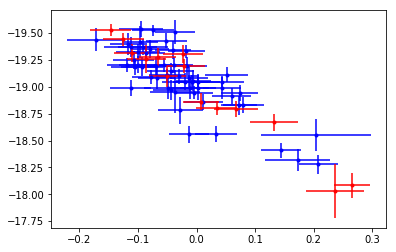

N_low = 55, N_high = 14
69


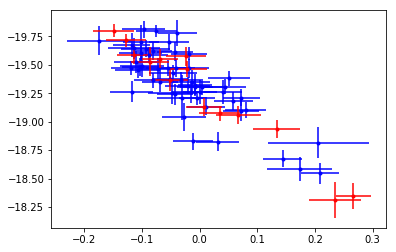

In [9]:
found_cosmo['x'] = found_cosmo['c']
found_cosmo['xerr'] = found_cosmo['c_err']
found_cosmo['y'] = found_cosmo['shp_cor']
found_cosmo['yerr'] = found_cosmo['shp_cor_err']
f_cosmo_split = split_data(found_cosmo)
print('N_low = {}, N_high = {}'.format(f_cosmo_split['n_lv'], f_cosmo_split['n_hv']))
print(f_cosmo_split['n_lv'] + f_cosmo_split['n_hv'])
plot_splitdata(f_cosmo_split)

found_ana['x'] = found_ana['c']
found_ana['xerr'] = found_ana['c_err']
found_ana['y'] = found_ana['shp_cor']
found_ana['yerr'] = found_ana['shp_cor_err']
f_ana_split = split_data(found_ana)
print('N_low = {}, N_high = {}'.format(f_ana_split['n_lv'], f_ana_split['n_hv']))
print(f_ana_split['n_lv'] + f_ana_split['n_hv'])
plot_splitdata(f_ana_split)

sampling slopes...


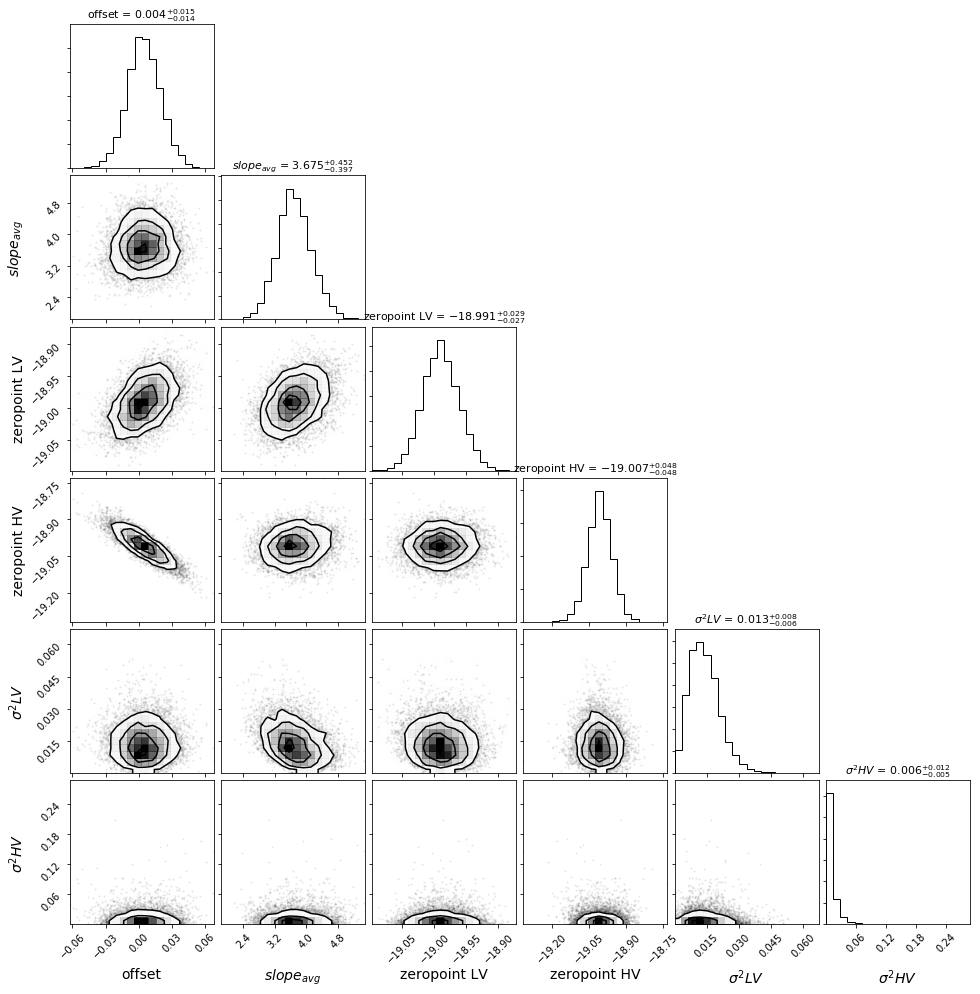

In [10]:
import random
random.seed(1766)

f_cosmo_sep_samp = dolinmix_sep(f_cosmo_split)

sampling slopes...


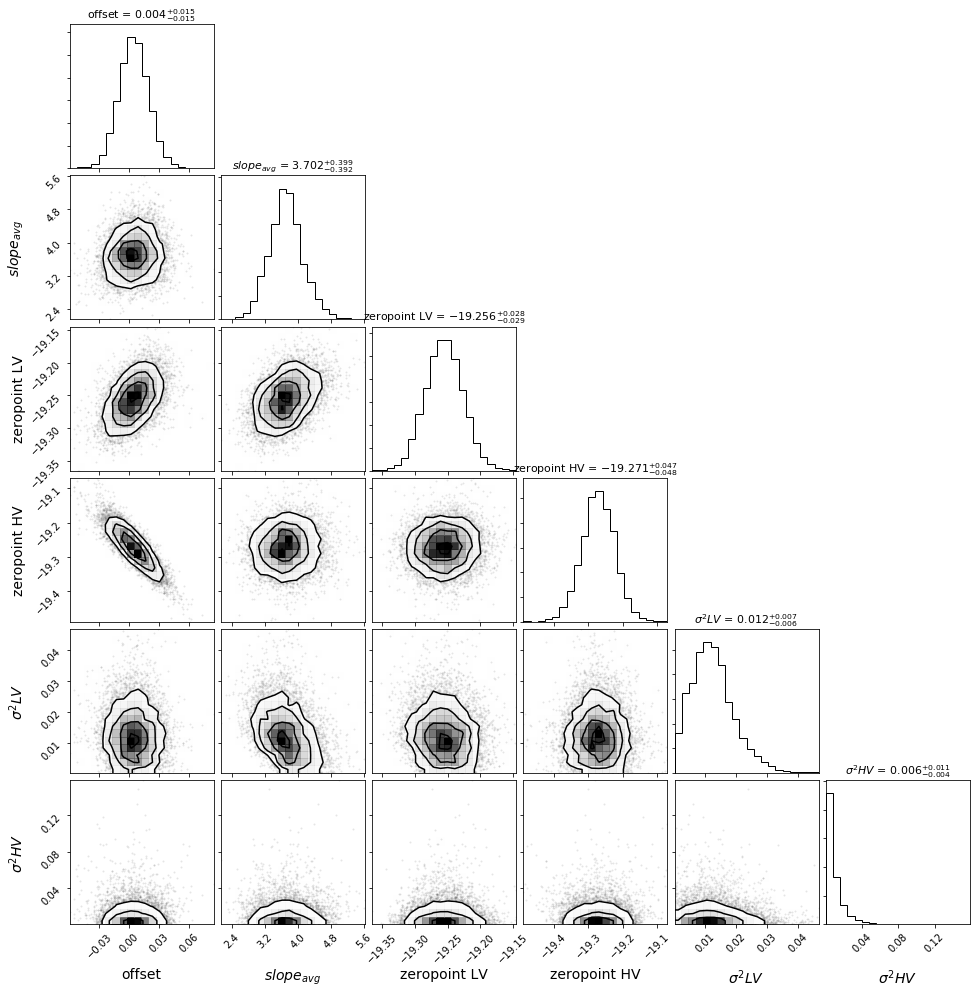

In [11]:
random.seed(1766)
f_ana_sep_samp = dolinmix_sep(f_ana_split)

N_low = 51, N_high = 14
65


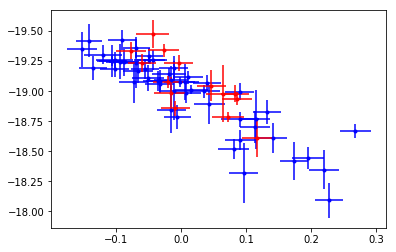

N_low = 51, N_high = 14
65


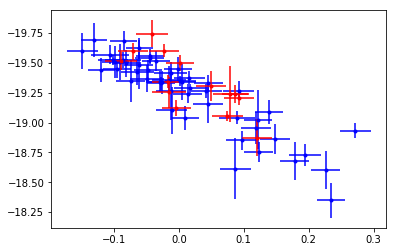

In [12]:
csp_cosmo['x'] = csp_cosmo['c']
csp_cosmo['xerr'] = csp_cosmo['c_err']
csp_cosmo['y'] = csp_cosmo['shp_cor']
csp_cosmo['yerr'] = csp_cosmo['shp_cor_err']
c_cosmo_split = split_data(csp_cosmo)
print('N_low = {}, N_high = {}'.format(c_cosmo_split['n_lv'], c_cosmo_split['n_hv']))
print c_cosmo_split['n_lv'] + c_cosmo_split['n_hv']
plot_splitdata(c_cosmo_split)

csp_ana['x'] = csp_ana['c']
csp_ana['xerr'] = csp_ana['c_err']
csp_ana['y'] = csp_ana['shp_cor']
csp_ana['yerr'] = csp_ana['shp_cor_err']
c_ana_split = split_data(csp_ana)
print('N_low = {}, N_high = {}'.format(c_ana_split['n_lv'], c_ana_split['n_hv']))
print c_ana_split['n_lv'] + c_ana_split['n_hv']
plot_splitdata(c_ana_split)

sampling slopes...
sampling slopes...


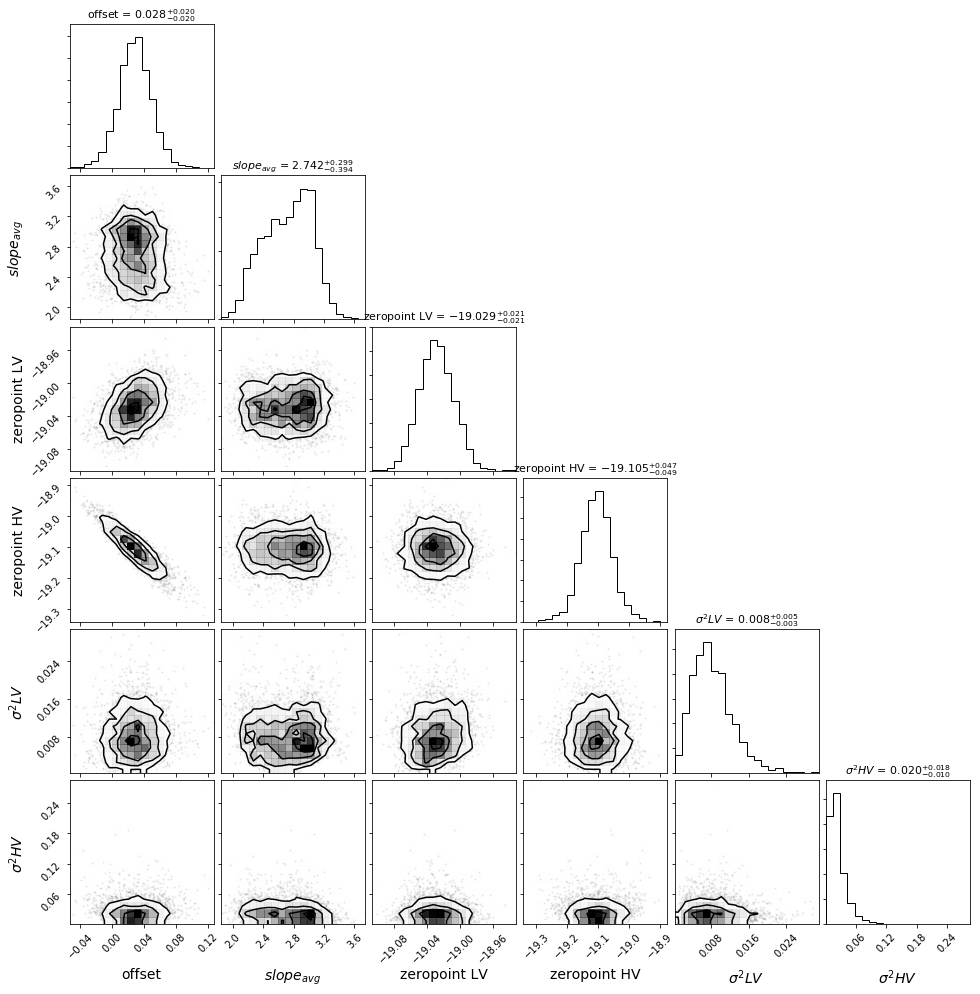

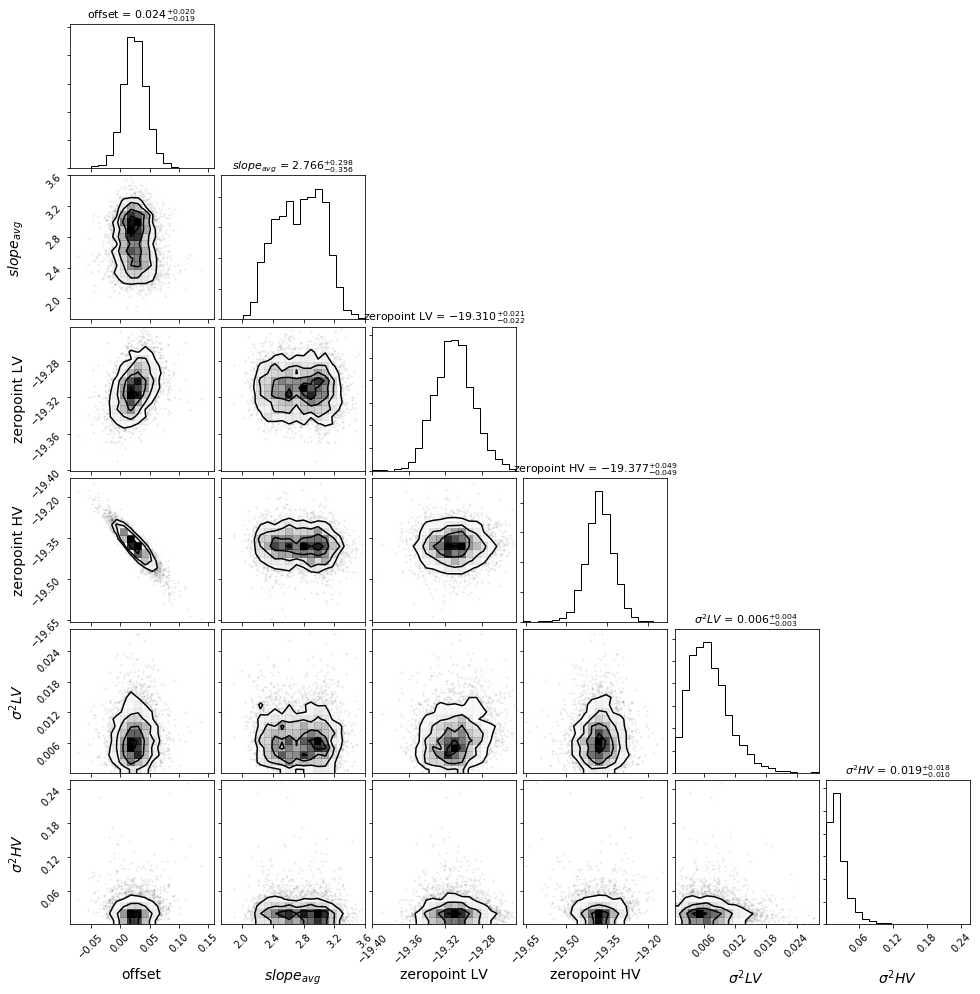

In [13]:
random.seed(1766)
c_cosmo_sep_samp = dolinmix_sep(c_cosmo_split)
c_ana_sep_samp = dolinmix_sep(c_ana_split)

N_low = 50, N_high = 14
64


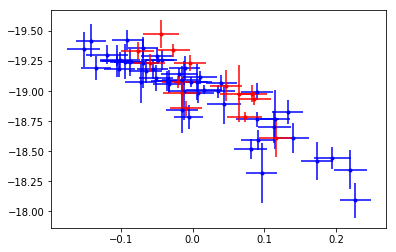

N_low = 50, N_high = 14
64


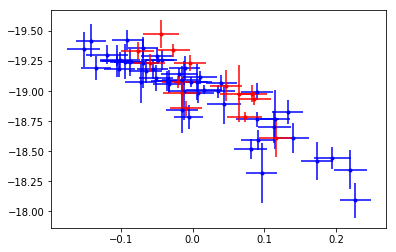

In [14]:
csp_cosmo_ryan = csp_cosmo[csp_cosmo.Name != '2007ba']
csp_ana_ryan = csp_cosmo[csp_ana.Name != '2007ba']

c_cosmo_ryan_split = split_data(csp_cosmo_ryan)
print('N_low = {}, N_high = {}'.format(c_cosmo_ryan_split['n_lv'], c_cosmo_ryan_split['n_hv']))
print c_cosmo_ryan_split['n_lv'] + c_cosmo_ryan_split['n_hv']
plot_splitdata(c_cosmo_ryan_split)

c_ana_ryan_split = split_data(csp_ana_ryan)
print('N_low = {}, N_high = {}'.format(c_ana_ryan_split['n_lv'], c_ana_ryan_split['n_hv']))
print c_ana_ryan_split['n_lv'] + c_ana_ryan_split['n_hv']
plot_splitdata(c_ana_ryan_split)

sampling slopes...
sampling slopes...


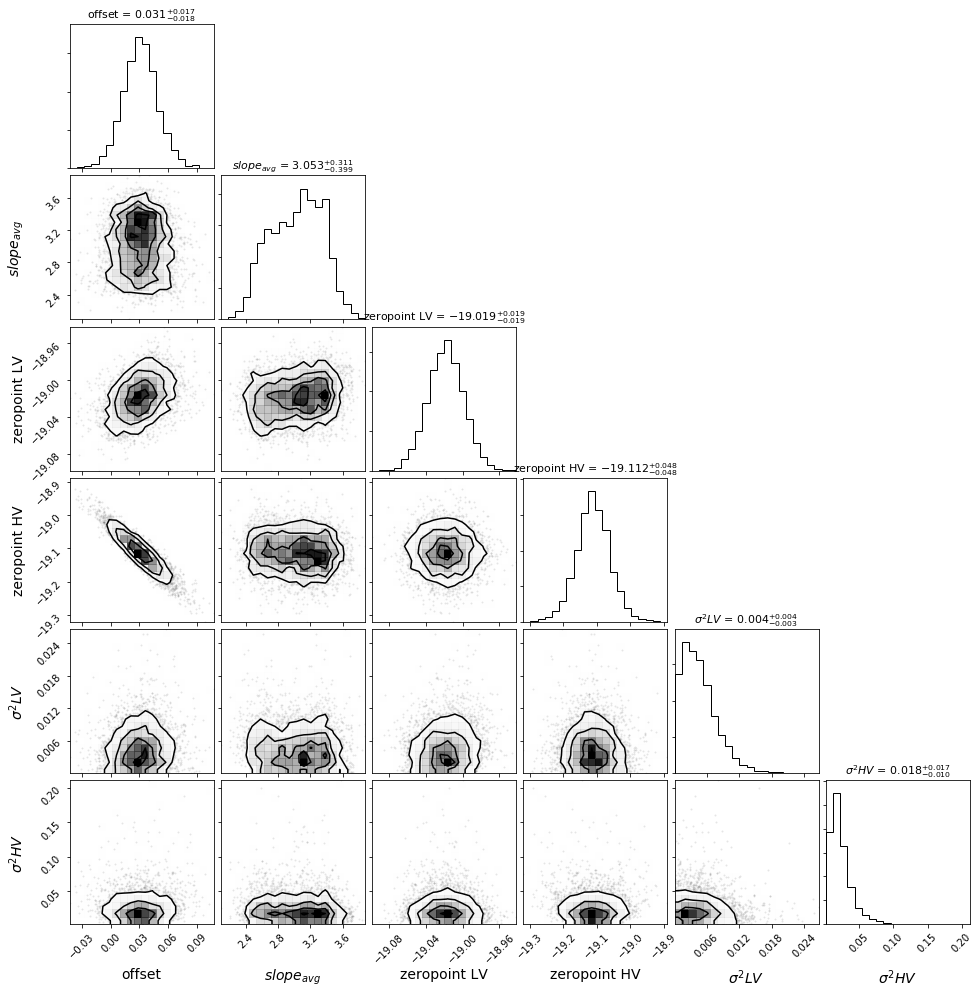

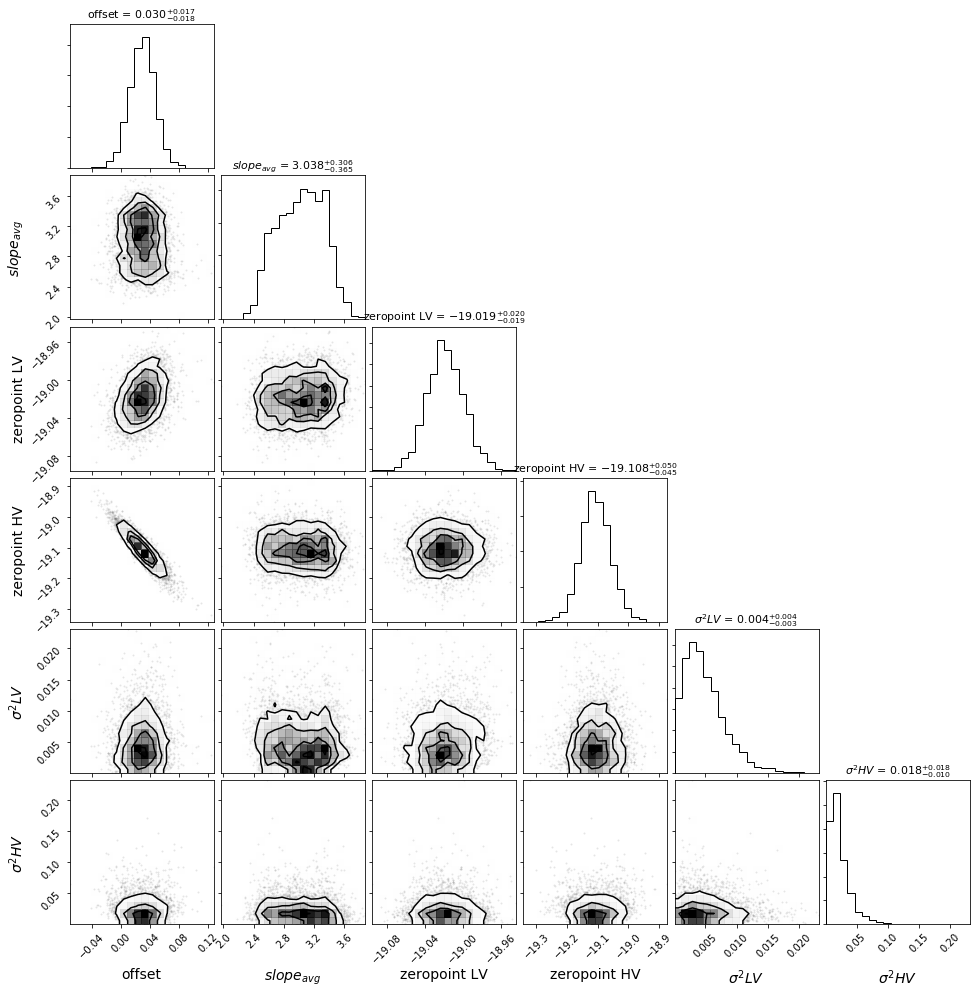

In [15]:
random.seed(1766)
c_cosmo_ryan_sep_samp = dolinmix_sep(c_cosmo_ryan_split)
c_ana_ryan_sep_samp = dolinmix_sep(c_ana_ryan_split)

N_low = 50, N_high = 14
64


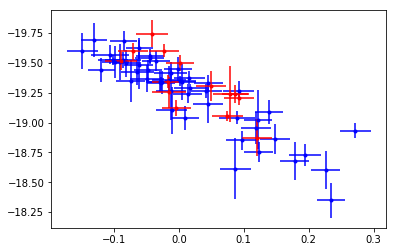

In [16]:
csp_ana_allmeas = csp_ana[np.abs(csp_ana.vel) < 90]

c_ana_allmeas_split = split_data(csp_ana_allmeas)
print('N_low = {}, N_high = {}'.format(c_ana_allmeas_split['n_lv'], c_ana_allmeas_split['n_hv']))
print c_ana_allmeas_split['n_lv'] + c_ana_allmeas_split['n_hv']
plot_splitdata(c_ana_allmeas_split)

sampling slopes...


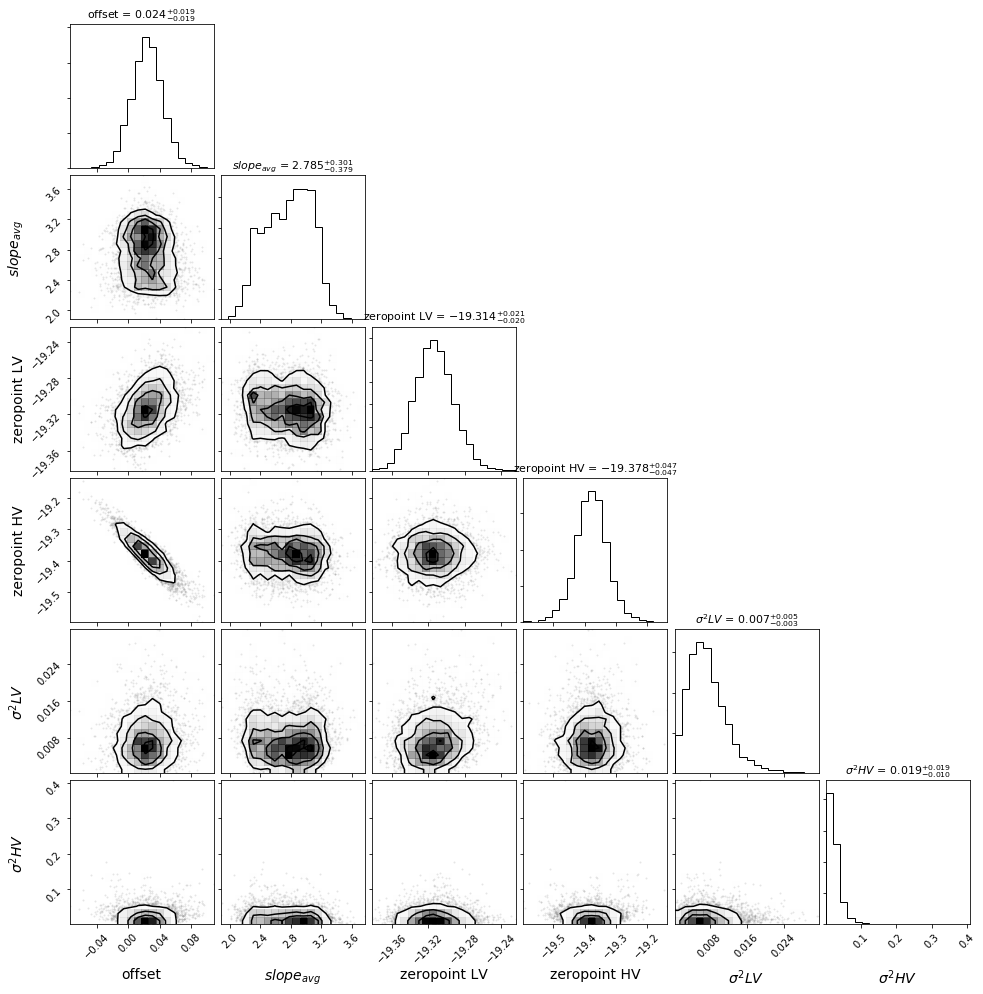

In [17]:
csp_ana_allmeas_sep_samp = dolinmix_sep(c_ana_allmeas_split)

N_low = 72, N_high = 25
97


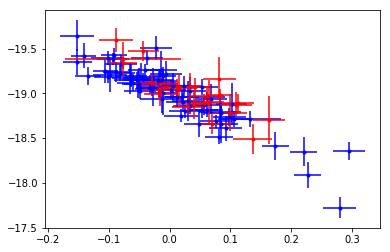

N_low = 72, N_high = 25
97


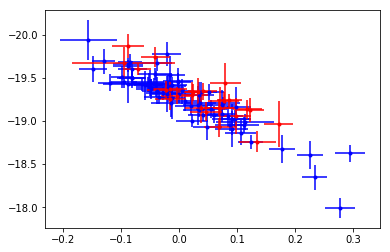

In [18]:
w09_cosmo['x'] = w09_cosmo['c']
w09_cosmo['xerr'] = w09_cosmo['c_err']
w09_cosmo['y'] = w09_cosmo['shp_cor']
w09_cosmo['yerr'] = w09_cosmo['shp_cor_err']
w_cosmo_split = split_data(w09_cosmo)
print('N_low = {}, N_high = {}'.format(w_cosmo_split['n_lv'], w_cosmo_split['n_hv']))
print w_cosmo_split['n_lv'] + w_cosmo_split['n_hv']
plot_splitdata(w_cosmo_split)

w09_ana['x'] = w09_ana['c']
w09_ana['xerr'] = w09_ana['c_err']
w09_ana['y'] = w09_ana['shp_cor']
w09_ana['yerr'] = w09_ana['shp_cor_err']
w_ana_split = split_data(w09_ana)
print('N_low = {}, N_high = {}'.format(w_ana_split['n_lv'], w_ana_split['n_hv']))
print w_ana_split['n_lv'] + w_ana_split['n_hv']
plot_splitdata(w_ana_split)

sampling slopes...
sampling slopes...


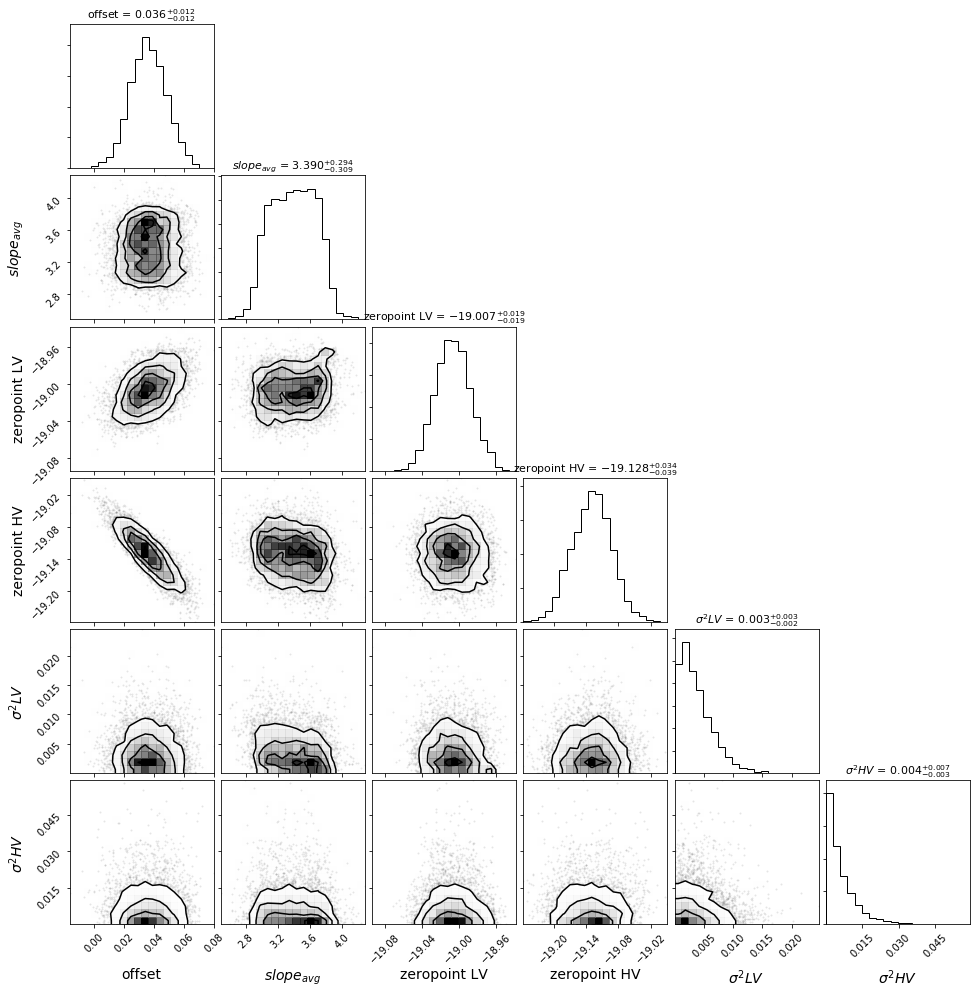

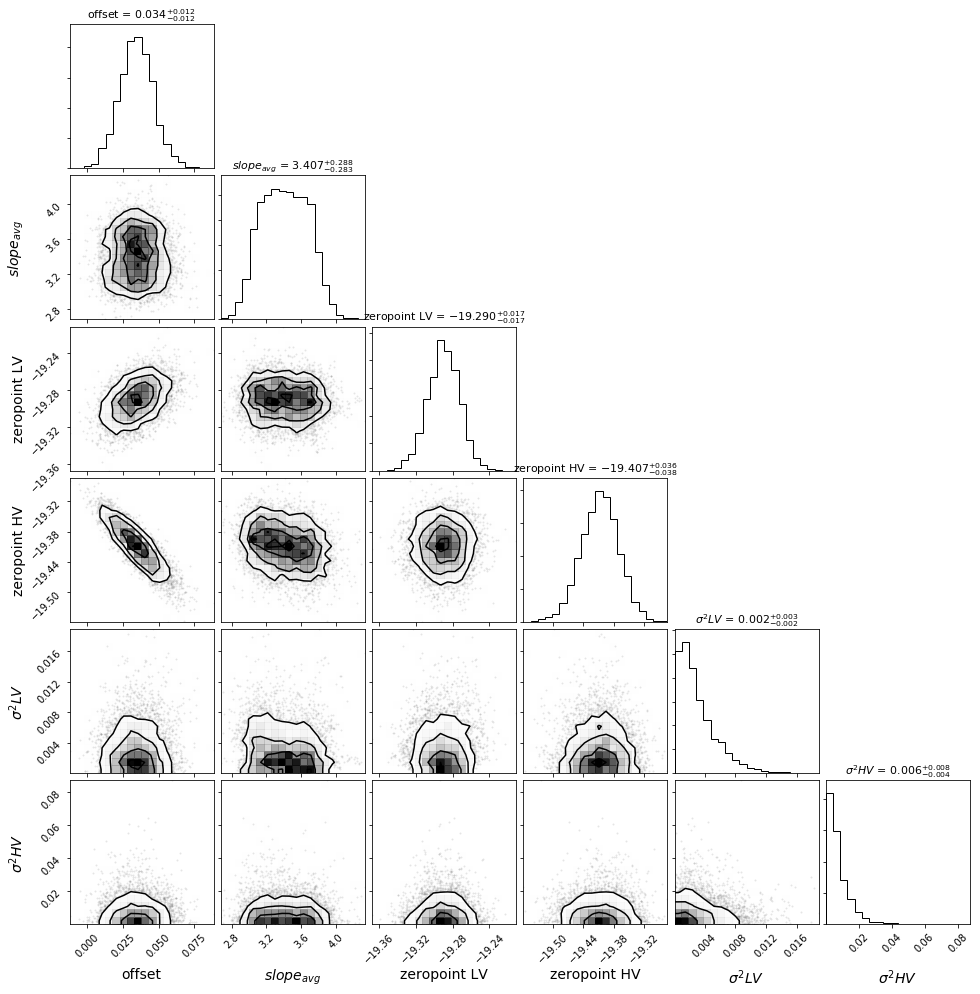

In [19]:
random.seed(1766)
w_cosmo_sep_samp = dolinmix_sep(w_cosmo_split)
w_ana_sep_samp = dolinmix_sep(w_ana_split)

N_low = 67, N_high = 24
91


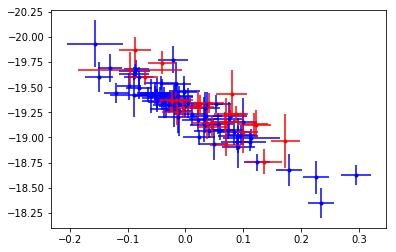

In [20]:
w09_ana_allmeas = w09_ana[np.abs(w09_ana.vel) < 90]

w09_ana_allmeas_split = split_data(w09_ana_allmeas)
print('N_low = {}, N_high = {}'.format(w09_ana_allmeas_split['n_lv'], w09_ana_allmeas_split['n_hv']))
print w09_ana_allmeas_split['n_lv'] + w09_ana_allmeas_split['n_hv']
plot_splitdata(w09_ana_allmeas_split)

sampling slopes...


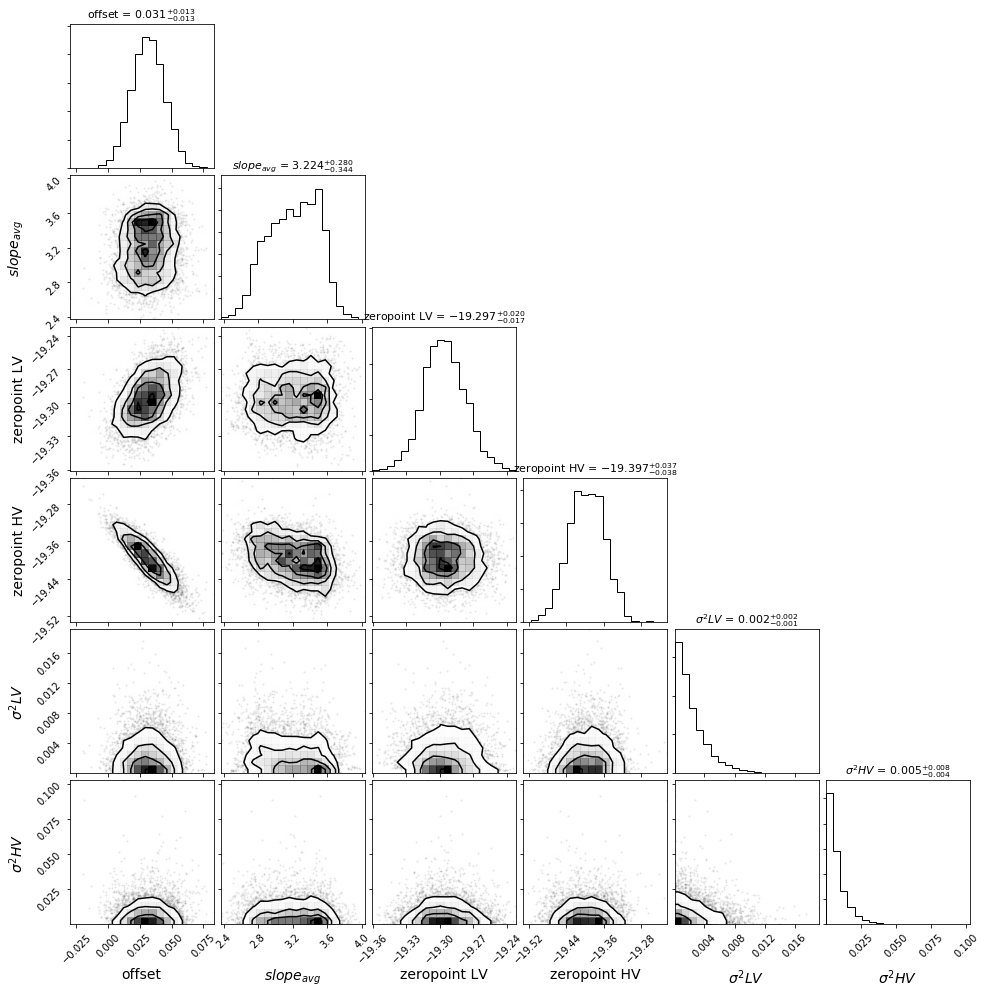

In [21]:
w09_ana_allmeas_sep_samp = dolinmix_sep(w09_ana_allmeas_split)

Several helper functions to create the final plot. `plotShpCor` plots the split data from earlier. `write_off_N` writes the details of the fit to each sample on the plot. `fourPlot_square` creates the final 2X2 style plot.

In [22]:
def plotShpCor(splitdata, ax, title, xlabel=True, ylabel=True):
    ax.errorbar(splitdata['x_lv'],splitdata['y_lv'],
                 splitdata['y_lv_err'],splitdata['x_lv_err'],'.b')
    ax.errorbar(splitdata['x_hv'],splitdata['y_hv'],
                 splitdata['y_hv_err'],splitdata['x_hv_err'],'.r')
    if (ylabel):
        ax.set_ylabel(r"$m_b - \mu_z + \alpha x_1$")
    if (xlabel):
        ax.set_xlabel('c [SALT2]')
    ax.set_title(title)
    ax.set_ylim(ax.get_ylim()[::-1])
    
def write_off_N(ax, split, samp, pos_fit, pos_N):
    percentiles_sc = np.percentile(samp, [16,84], axis=0)
    offset_sc = np.median(samp[:,0])
    offset_sc_unc = np.mean([np.abs(percentiles_sc[:,0][0] - offset_sc), 
                             np.abs(percentiles_sc[:,0][1] - offset_sc)])
    
    
    slope_sc = np.median(samp[:,1])
    slope_sc_unc = np.mean([np.abs(percentiles_sc[:,1][0] - slope_sc), 
                            np.abs(percentiles_sc[:,1][1] - slope_sc)])
    
    ax.text(pos_fit[0],pos_fit[1]+0.2, r'color offset = {:.3f} $\pm$ {:.3f}'
            .format(offset_sc, offset_sc_unc),
            fontsize=18)
    ax.text(pos_fit[0],pos_fit[1], r'$\beta$ = {:.2f} $\pm$ {:.2f}'
            .format(slope_sc, slope_sc_unc),
            fontsize=18)
    ax.text(pos_N[0],pos_N[1]-0.18, r'$N_\mathrm{high\ velocity} =$' + '{:d}'.format(split['n_hv']), 
             fontsize=16, color='r')
    ax.text(pos_N[0],pos_N[1], r'$N_\mathrm{normal} =$' + '{:d}'.format(split['n_lv']), 
             fontsize=16, color='b')
    
def fourPlot_square(splitdata1, samp1, label1, 
                   splitdata2, samp2, label2, 
                   splitdata3, samp3, label3, 
                   splitdata4, samp4, label4):
    
    matplotlib.rcParams["mathtext.fontset"] = "stix"
    matplotlib.rcParams["font.family"] = "STIXGeneral"
    matplotlib.rcParams["lines.linewidth"] = 2
    matplotlib.rcParams["axes.linewidth"] = 1.2
    matplotlib.rcParams["xtick.major.size"] = 8.0
    matplotlib.rcParams["ytick.major.size"] = 8.0
    matplotlib.rcParams["xtick.minor.size"] = 3.0
    matplotlib.rcParams["ytick.minor.size"] = 3.0
    matplotlib.rcParams["xtick.minor.visible"] = True
    matplotlib.rcParams["xtick.direction"] = "in"
    matplotlib.rcParams["ytick.minor.visible"] = True
    matplotlib.rcParams["ytick.direction"] = "in"
    matplotlib.rcParams["xtick.top"] = True
    matplotlib.rcParams["ytick.right"] = True
    
    # Controls where the name of the sample goes
    label_loc = (-0.22,-18.4)
    # Controls where the linmix fit results go
    fit_loc = (-0.22,-18.2)
    # Control where the number of SNe go
    n_loc = (0.1,-19.55)
    
    fig, ax = plt.subplots(2,2,sharex=True,gridspec_kw={'wspace':0.0,'hspace':0.0})
    fig.set_size_inches(fig.get_size_inches()[0]*2.1,fig.get_size_inches()[1]*2.1)
    
    plotFit_sep(samp1, splitdata1, ax=ax[0,0])
    ax[0,0].text(label_loc[0],label_loc[1],label1,fontsize=22)
    plotFit_sep(samp2, splitdata2, ax=ax[1,0])
    ax[1,0].text(label_loc[0],label_loc[1],label2,fontsize=22)
    plotFit_sep(samp3, splitdata3, ax=ax[0,1])
    ax[0,1].text(label_loc[0],label_loc[1],label3,fontsize=22)
    plotFit_sep(samp4, splitdata4, ax=ax[1,1])
    ax[1,1].text(label_loc[0],label_loc[1],label4,fontsize=22)
    
    ax[0,0].set_ylim([-17.8,-20.1])
    ax[1,0].set_ylim([-17.8,-20.1])
    ax[0,1].set_ylim([-17.8,-20.1])
    ax[1,1].set_ylim([-17.8,-20.1])
    
    ax[0,0].tick_params(labelsize=16, labelbottom=False)
    ax[1,0].tick_params(labelsize=16)
    ax[0,1].tick_params(labelleft=False,labelbottom=False)
    ax[1,1].tick_params(axis='x',labelsize=16)
    ax[1,1].tick_params(axis='y',labelleft=False)
    
    write_off_N(ax[0,0], splitdata1, samp1, (fit_loc[0],fit_loc[1]),(n_loc[0],n_loc[1]))
    write_off_N(ax[1,0], splitdata2, samp2, (fit_loc[0],fit_loc[1]),(n_loc[0],n_loc[1]))
    write_off_N(ax[0,1], splitdata3, samp3, (fit_loc[0],fit_loc[1]),(n_loc[0],n_loc[1]))
    write_off_N(ax[1,1], splitdata4, samp4, (fit_loc[0],fit_loc[1]),(n_loc[0],n_loc[1]))
    
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r'Color, SALT2 $c$', fontsize=20, labelpad=20)
    plt.ylabel(r'Shape-corrected absolute magnitude, $m_B + \alpha x_1 - \mu_z$ [mag]', fontsize=20, labelpad=45)

Combining the three samples

In [23]:
comb_cosmo = pd.concat([csp_cosmo, w09_cosmo, found_cosmo])
comb_cosmo = comb_cosmo.drop_duplicates(subset='Name')

comb_ana = pd.concat([csp_ana, w09_ana, found_ana])
comb_ana = comb_ana.drop_duplicates(subset='Name')

209


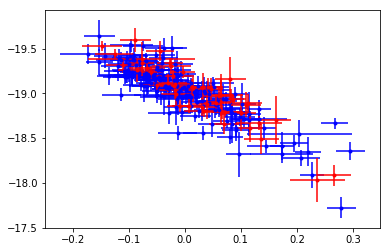

209


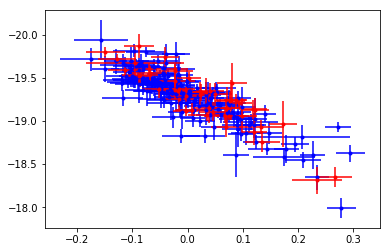

In [24]:
comb_cosmo['x'] = comb_cosmo['c']
comb_cosmo['xerr'] = comb_cosmo['c_err']
comb_cosmo['y'] = comb_cosmo['shp_cor']
comb_cosmo['yerr'] = comb_cosmo['shp_cor_err']
cb_cosmo_split = split_data(comb_cosmo)
print cb_cosmo_split['n_lv'] + cb_cosmo_split['n_hv']
plot_splitdata(cb_cosmo_split)

comb_ana['x'] = comb_ana['c']
comb_ana['xerr'] = comb_ana['c_err']
comb_ana['y'] = comb_ana['shp_cor']
comb_ana['yerr'] = comb_ana['shp_cor_err']
cb_ana_split = split_data(comb_ana)
print cb_ana_split['n_lv'] + cb_ana_split['n_hv']
plot_splitdata(cb_ana_split)

sampling slopes...
sampling slopes...


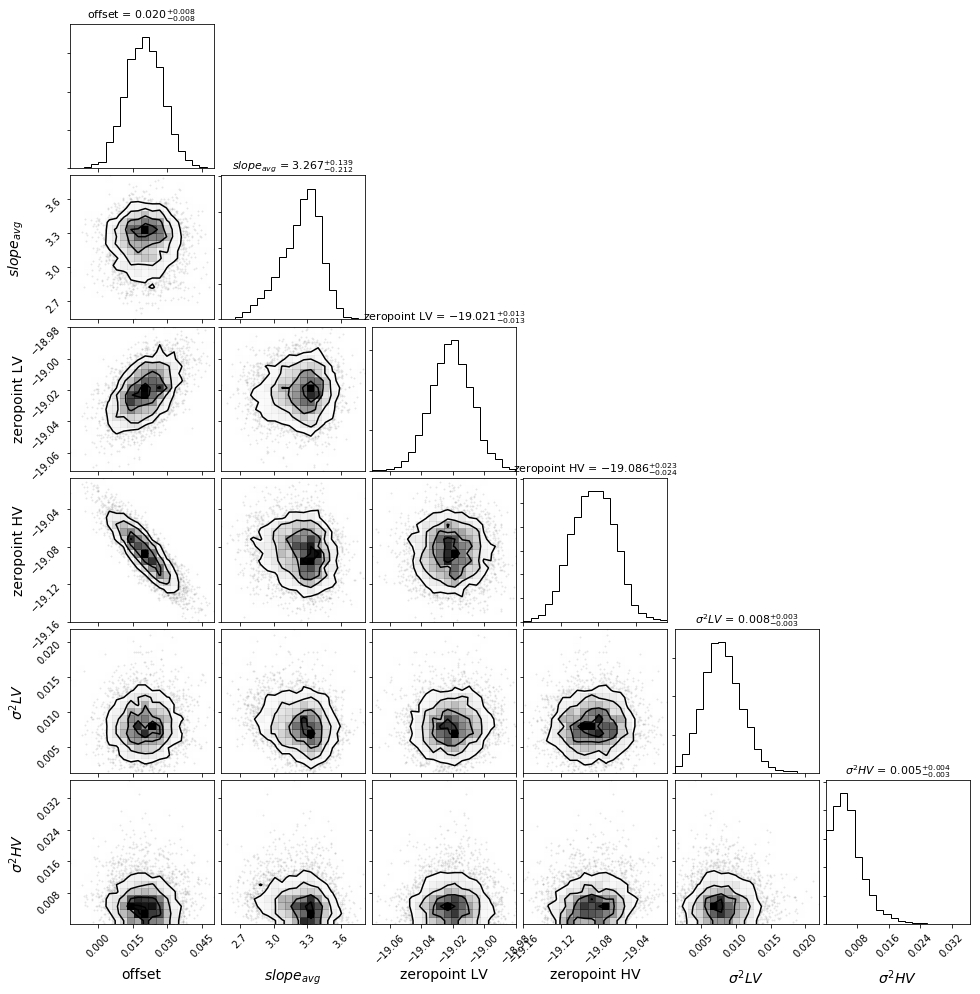

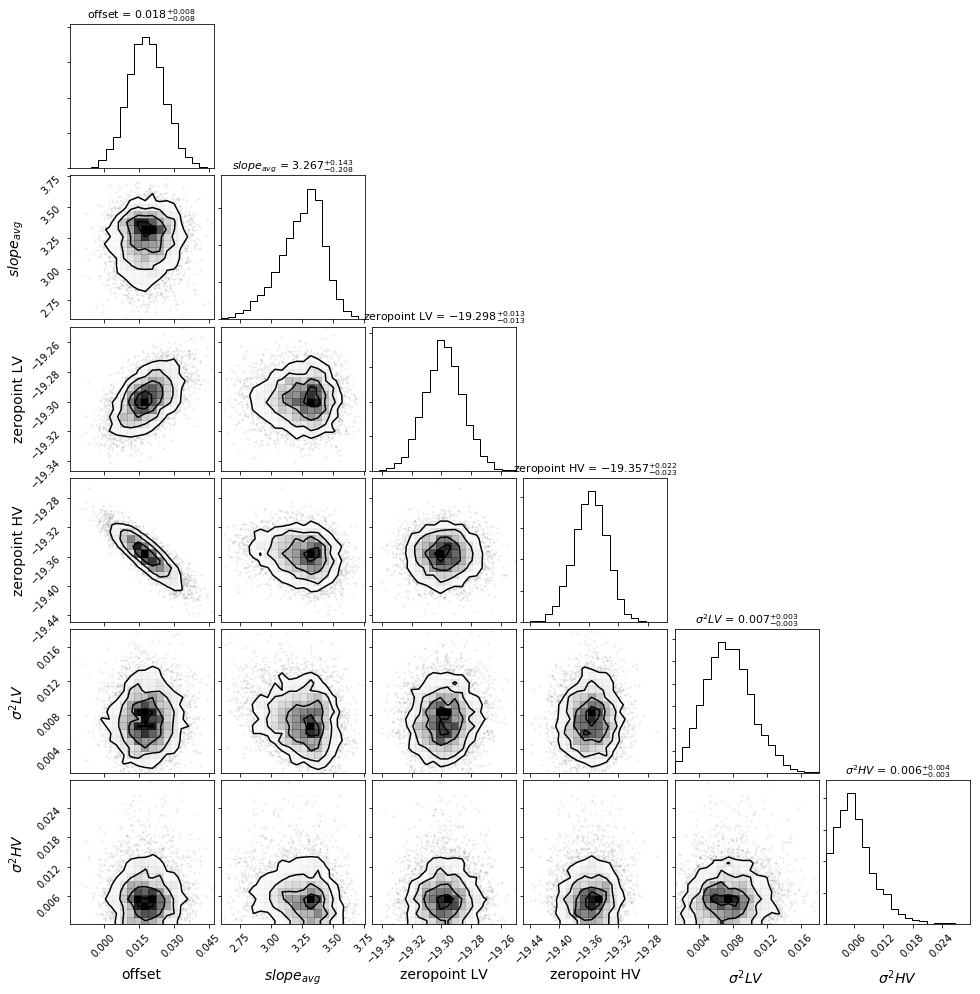

In [25]:
random.seed(1766)
cb_cosmo_sep_samp = dolinmix_sep(cb_cosmo_split)
cb_ana_sep_samp = dolinmix_sep(cb_ana_split)

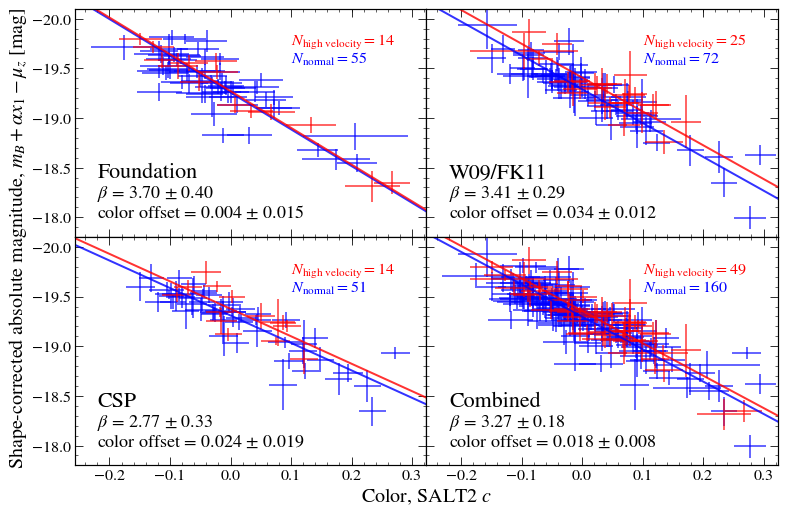

In [26]:
fourPlot_square(f_ana_split, f_ana_sep_samp, 'Foundation',
                c_ana_split, c_ana_sep_samp, 'CSP',
                w_ana_split, w_ana_sep_samp, 'W09/FK11',
                cb_ana_split, cb_ana_sep_samp, 'Combined')
plt.savefig('fourPlot_figures/fourPlot_2by2.pdf',bbox_inches='tight')

In [27]:
def outputTable(sample_list, labels, filename):
    for i, sample in enumerate(sample_list):
        sample = np.array(sample)
        percentiles = np.percentile(sample, [16,84], axis=0)
        offset = np.median(sample[:,0])
        offset_p = percentiles[:,0]
        offset_err = np.mean([np.abs(offset_p[0] - offset), 
                              np.abs(offset_p[1] - offset)])
        
        print('{} & {:.3f} & {:.3f} \\\\'.format(labels[i], offset, offset_err))
        with open(filename, 'a') as f:
            f.write('{} & {:.3f} & {:.3f} \\\\ \n'.format(labels[i], offset, offset_err))

In [28]:
outputTable([f_ana_sep_samp,c_ana_sep_samp,w_ana_sep_samp,cb_ana_sep_samp],
            ['Foundation [SNANA]','CSP [SNANA]','W09/FK11 [SNANA]','Combined Sample [SNANA]'],
            'fourPlot_tables/fits_snana.tex')

Foundation [SNANA] & 0.004 & 0.015 \\
CSP [SNANA] & 0.024 & 0.019 \\
W09/FK11 [SNANA] & 0.034 & 0.012 \\
Combined Sample [SNANA] & 0.018 & 0.008 \\


In [29]:
outputTable([f_cosmo_sep_samp,c_cosmo_sep_samp,w_cosmo_sep_samp,cb_cosmo_sep_samp],
            ['Foundation [sncosmo]','CSP [sncosmo]','W09/FK11 [sncosmo]','Combined Sample [sncosmo]'],
            'fourPlot_tables/fits_sncosmo.tex')

Foundation [sncosmo] & 0.004 & 0.015 \\
CSP [sncosmo] & 0.028 & 0.020 \\
W09/FK11 [sncosmo] & 0.036 & 0.012 \\
Combined Sample [sncosmo] & 0.020 & 0.008 \\
